In [4]:
import pandas as pd

# === Load dataset ===
df = pd.read_csv("merged_funding_price_data.csv", parse_dates=["Funding Time (UTC)"])

# === Parameters ===
initial_capital = 100.0
capital = initial_capital
leverage = 5
btc_rebalance_threshold = 0.20
ethbtc_rebalance_threshold = 0.20
btc_fee_rate = 0.0028
eth_fee_rate = 0.0020
btc_borrow_rate_annual = 0.01
btc_borrow_rate_daily = btc_borrow_rate_annual / 365

# === Tracking ===
equity_curve = []
rebalance_log = []
funding_received_total = 0.0
btc_borrow_cost_total = 0.0
btc_rebalance_price = None
ethbtc_rebalance_ratio = None
btc_position = 0.0
short_position = 0.0

# === Backtest loop ===
for _, row in df.iterrows():
    timestamp = row["Funding Time (UTC)"]
    funding_rate = row["Funding Rate (%)"] / 100
    btc_price = row["BTC Close"]
    ethbtc_price = row["ETHBTC Close"]

    if pd.isna(btc_price) or pd.isna(ethbtc_price):
        continue

    # === Initial Position Setup ===
    if btc_rebalance_price is None:
        btc_rebalance_price = btc_price
        ethbtc_rebalance_ratio = ethbtc_price

        btc_exposure = leverage * (capital / 2)  # $250 BTC long, $50 ETH collateral
        btc_position = btc_exposure / btc_price
        short_position = -btc_exposure / btc_price
        continue

    # === Funding from perp short ===
    notional_short = leverage * (capital / 2)
    funding_payment = notional_short * funding_rate
    capital += funding_payment
    funding_received_total += funding_payment

    # === BTC Borrow Cost (on borrowed $200 BTC) ===
    btc_exposure = leverage * (capital / 2)
    borrowed_btc = (btc_exposure - (capital / 2)) / btc_price
    btc_borrow_cost = borrowed_btc * btc_price * btc_borrow_rate_daily
    capital -= btc_borrow_cost
    btc_borrow_cost_total += btc_borrow_cost

    # === Rebalance Triggers ===
    btc_trigger = (btc_price / btc_rebalance_price - 1) >= btc_rebalance_threshold
    eth_trigger = (ethbtc_price / ethbtc_rebalance_ratio - 1) <= -ethbtc_rebalance_threshold

    fees = 0.0
    did_rebalance = False

    if btc_trigger:
        btc_notional = abs(short_position) * btc_price
        fees += btc_fee_rate * btc_notional
        short_position = -btc_exposure / btc_price
        btc_rebalance_price = btc_price
        did_rebalance = True

    if eth_trigger:
        eth_notional = abs(btc_position) * btc_price
        fees += eth_fee_rate * eth_notional
        btc_position = btc_exposure / btc_price
        ethbtc_rebalance_ratio = ethbtc_price
        did_rebalance = True

    if did_rebalance:
        capital -= fees
        rebalance_log.append((timestamp, btc_price, ethbtc_price, fees))

    equity_curve.append((timestamp, capital))

# === Export results ===
equity_df = pd.DataFrame(equity_curve, columns=["Timestamp", "Equity"])
rebalance_df = pd.DataFrame(rebalance_log, columns=["Timestamp", "BTC Price", "ETHBTC", "Fees"])

equity_df.to_csv("equity_curve_final.csv", index=False)
rebalance_df.to_csv("rebalancing_log_final.csv", index=False)

# === Summary ===
print("✅ Backtest complete.")
print(f"📈 Final Equity: ${equity_df['Equity'].iloc[-1]:,.2f}")
print(f"🔁 Total Rebalances: {len(rebalance_log)}")
print(f"💸 Total Funding Received: ${funding_received_total:,.2f}")
print(f"💸 Total BTC Borrow Cost: ${btc_borrow_cost_total:,.2f}")
print(f"📉 Net Return after BTC Borrow: ${(equity_df['Equity'].iloc[-1] - initial_capital):,.2f}")


✅ Backtest complete.
📈 Final Equity: $364.08
🔁 Total Rebalances: 13
💸 Total Funding Received: $362.63
💸 Total BTC Borrow Cost: $77.64
📉 Net Return after BTC Borrow: $264.08


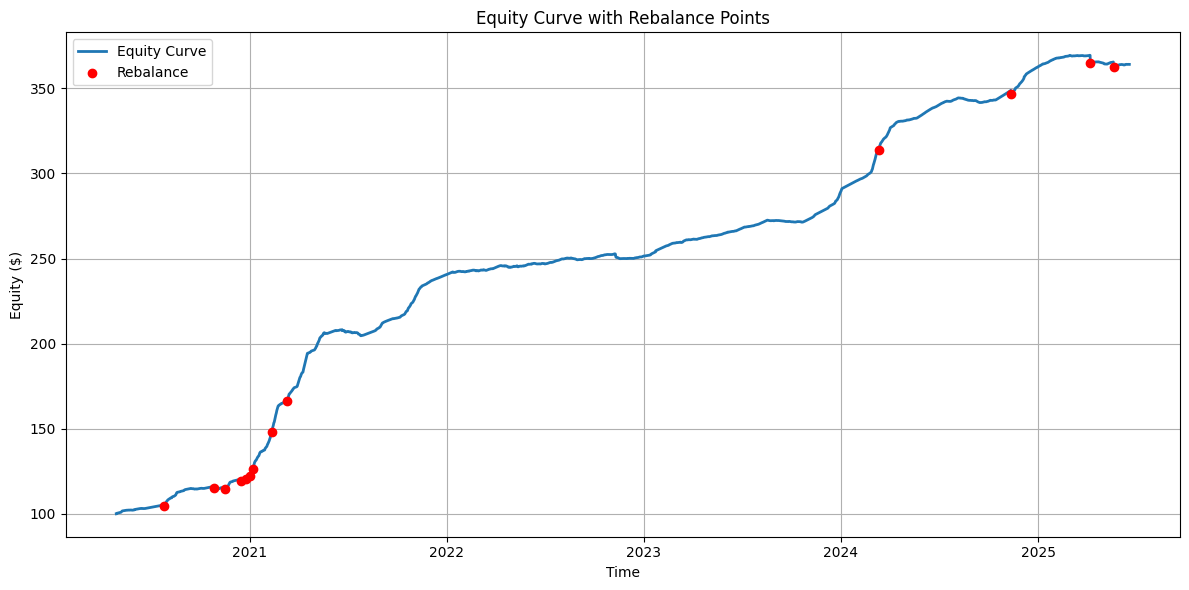

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Load data if not already loaded
equity_df = pd.read_csv("equity_curve_final.csv", parse_dates=["Timestamp"])
rebalance_df = pd.read_csv("rebalancing_log_final.csv", parse_dates=["Timestamp"])

plt.figure(figsize=(12, 6))
plt.plot(equity_df["Timestamp"], equity_df["Equity"], label="Equity Curve", linewidth=2)

# Plot rebalance points
plt.scatter(rebalance_df["Timestamp"],
            equity_df[equity_df["Timestamp"].isin(rebalance_df["Timestamp"])]["Equity"],
            color='red', label="Rebalance", zorder=5)

plt.xlabel("Time")
plt.ylabel("Equity ($)")
plt.title("Equity Curve with Rebalance Points")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
import numpy as np

# === Calculate period-over-period return ===
equity_df["Return"] = equity_df["Equity"].pct_change()

# === Assumptions ===
risk_free_rate = 0.0
periods_per_year = 1095  # 8-hour intervals × 365

# === Metrics ===
mean_return = equity_df["Return"].mean()
std_return = equity_df["Return"].std()
downside_std = equity_df["Return"][equity_df["Return"] < 0].std()

# Sharpe Ratio
sharpe_ratio = (mean_return - risk_free_rate) / std_return * np.sqrt(periods_per_year) if std_return > 0 else 0

# Sortino Ratio
sortino_ratio = (mean_return - risk_free_rate) / downside_std * np.sqrt(periods_per_year) if downside_std > 0 else 0

# CAGR
start_value = equity_df["Equity"].iloc[0]
end_value = equity_df["Equity"].iloc[-1]
start_date = equity_df["Timestamp"].iloc[0]
end_date = equity_df["Timestamp"].iloc[-1]
years = (end_date - start_date).days / 365.0
cagr = (end_value / start_value) ** (1 / years) - 1

# Max Drawdown
equity_df["Running Max"] = equity_df["Equity"].cummax()
equity_df["Drawdown"] = equity_df["Equity"] / equity_df["Running Max"] - 1
max_drawdown = equity_df["Drawdown"].min()

# Calmar Ratio
calmar_ratio = cagr / abs(max_drawdown) if max_drawdown != 0 else np.nan

# Total Return
total_return = (end_value / start_value - 1)

# === Output Summary ===
print("===== PERFORMANCE SUMMARY =====")
print(f"💰 Final Equity:      ${end_value:,.2f}")
print(f"📊 Total Return:      {total_return:.2%}")
print(f"📈 CAGR:              {cagr:.2%}")
print(f"📉 Max Drawdown:      {max_drawdown:.2%}")
print(f"📐 Sharpe Ratio:      {sharpe_ratio:.2f}")
print(f"⚠️ Sortino Ratio:     {sortino_ratio:.2f}")
print(f"💥 Calmar Ratio:      {calmar_ratio:.2f}")
print(f"🔁 Total Rebalances:  {len(rebalance_df)}")
print("================================")


===== PERFORMANCE SUMMARY =====
💰 Final Equity:      $364.08
📊 Total Return:      264.00%
📈 CAGR:              28.58%
📉 Max Drawdown:      -1.85%
📐 Sharpe Ratio:      11.68
⚠️ Sortino Ratio:     9.13
💥 Calmar Ratio:      15.48
🔁 Total Rebalances:  13


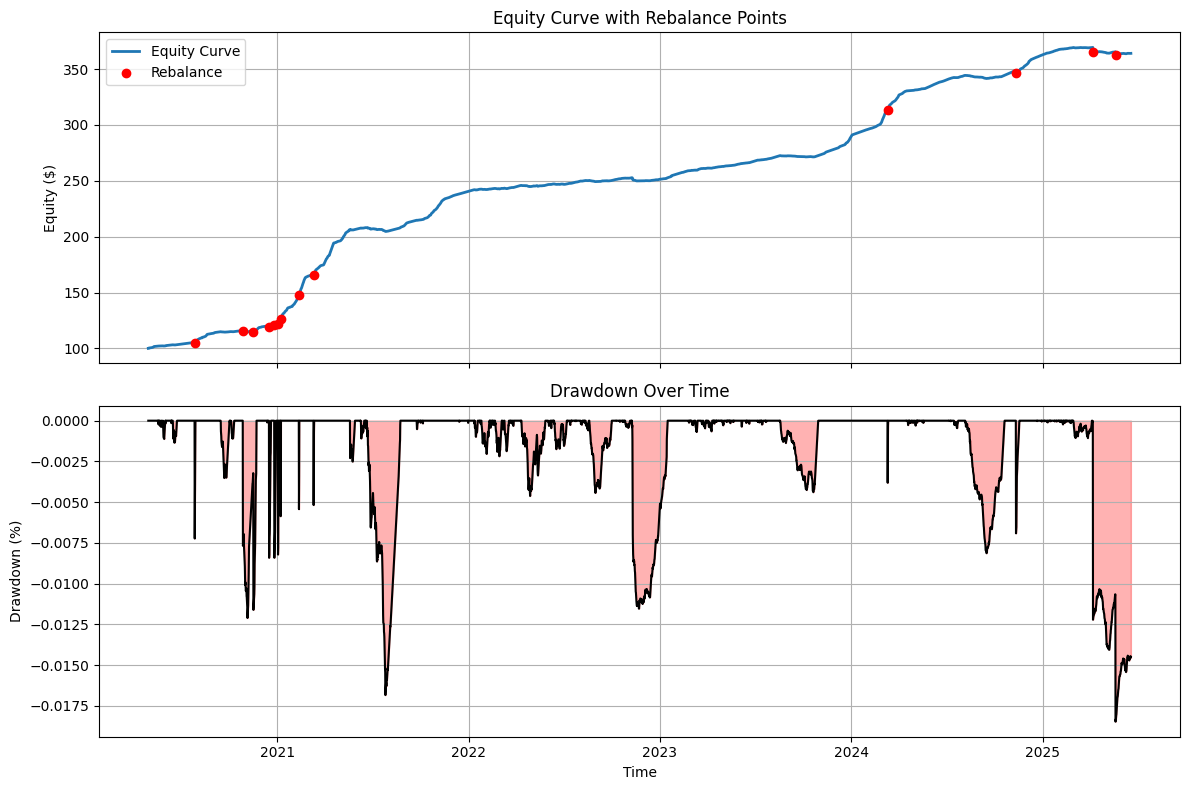

In [2]:
import numpy as np

# Compute drawdown
equity_df["Running Max"] = equity_df["Equity"].cummax()
equity_df["Drawdown"] = equity_df["Equity"] / equity_df["Running Max"] - 1

# Plot equity + drawdown
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Equity curve
ax1.plot(equity_df["Timestamp"], equity_df["Equity"], label="Equity Curve", linewidth=2)
ax1.scatter(rebalance_points["Timestamp"], rebalance_points["Equity"],
            color='red', label="Rebalance", zorder=5)
ax1.set_ylabel("Equity ($)")
ax1.set_title("Equity Curve with Rebalance Points")
ax1.legend()
ax1.grid(True)

# Drawdown
ax2.plot(equity_df["Timestamp"], equity_df["Drawdown"], color="black")
ax2.fill_between(equity_df["Timestamp"], equity_df["Drawdown"], 0, color="red", alpha=0.3)
ax2.set_ylabel("Drawdown (%)")
ax2.set_xlabel("Time")
ax2.set_title("Drawdown Over Time")
ax2.grid(True)

plt.tight_layout()
plt.savefig("strategy_performance_summary.png", dpi=300)
plt.show()
